# Homework 4

## More trains

For this homework, you will be working with the real-time stream of the NS, the train company of the Netherlands. You can see an example webpage that uses this same stream to display the train information on a map: https://spoorkaart.mwnn.nl/ . 

To help you and avoid having too many connections to the NS streaming servers, we have setup a service that collects the streams and pushes them to our Kafka instance. The related topics are: 

`ndovloketnl-arrivals` : For each arrival of a train in a station, describe the previous and next station, time of arrival (planned and actual), track number,...

`ndovloketnl-departures`: For each departure of a train from a station, describe the previous and next station, time of departure (planned and actual), track number,...

`ndovloketnl-gps`: For each train, describe the current location, speed, bearing.

The events are serialized in json (actually converted from xml), with properties in their original language. Google translate could help you understand all of them, but we will provide you some useful mapping.

## Import

In [1]:
import os
import math
import time
import json
import getpass
import pyspark
import numpy as np
import pandas as pd

from datetime import datetime

from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext
from pyspark.streaming.kafka import KafkaUtils, OffsetRange

from pykafka import KafkaClient
from pykafka.common import OffsetType

from bokeh.plotting import figure
from bokeh.io import push_notebook, show, output_notebook
from bokeh.tile_providers import CARTODBPOSITRON, CARTODBPOSITRON_RETINA
from bokeh.models import ColumnDataSource, Range1d, LabelSet, Label, HoverTool

from pyproj import Proj, transform

## Start a Spark Session

In [2]:
username = getpass.getuser()

# You can run on your computer or on the cluster
# If running on the computer make sure that pykafka==2.8.0 is installed
# Use this when running on your computer
# spark = (SparkSession
#         .builder
#         .appName('streaming-{0}'.format(username))
#         .master('local[4]') # this number must be greater than the number of sources
#         .config('spark.executor.memory', '1g')
#         .config('spark.jars.packages', 'org.apache.spark:spark-streaming-kafka-0-8_2.11:2.3.2')
#         .getOrCreate())

# Use this when running on the cluster
os.environ['PYSPARK_PYTHON'] = '/opt/anaconda3/bin/python'
spark = (SparkSession
         .builder
         .appName('streaming-{0}'.format(username))
         .master('yarn')
         .config('spark.executor.memory', '4g')
         .config('spark.executor.instances', '2')
         .config('spark.executor.cores', '2')
         .config('spark.jars.packages', 'org.apache.spark:spark-streaming-kafka-0-8_2.11:2.3.2')
         .config('spark.port.maxRetries', '100')
         .getOrCreate())

sc = spark.sparkContext
conf = sc.getConf()

spark

## Start a Kafka Client

In [3]:
ZOOKEEPER_QUORUM = 'iccluster042.iccluster.epfl.ch:2181, \
                    iccluster054.iccluster.epfl.ch:2181, \
                    iccluster078.iccluster.epfl.ch:2181'

client = KafkaClient(zookeeper_hosts=ZOOKEEPER_QUORUM)

# Preliminary - Data Preparation

## Static RDDs from Kafka

Working on data streams is often times more complex compared to using static datasets, so we will first look at how to create static RDDs for easy prototyping.

You can find below a function that creates a static RDD from a Kafka topic.

In [4]:
def create_static_rdd_from_kafka(topic, from_offset, to_offset):
    if isinstance(topic, bytes):
        topic = topic.decode('utf-8')
    return KafkaUtils.createRDD(sc, {'bootstrap.servers': 'iccluster042.iccluster.epfl.ch:6667'},
                                [OffsetRange(topic, 0, from_offset, to_offset)])

To check this function, we need to retrieve valid offsets from Kafka.

In [5]:
topic = client.topics[b'ndovloketnl-arrivals']
topic.earliest_available_offsets()

{0: OffsetPartitionResponse(offset=[1058058], err=0)}

Now, we can for example retrieve the first 1000 messages from the topic `ndovloketnl-arrivals`.

In [6]:
offset = topic.earliest_available_offsets()[0].offset[0]
rdd = create_static_rdd_from_kafka(b'ndovloketnl-arrivals', offset, offset+1000)

In [7]:
rdd.first()

(None,
 '{"ns1:PutReisInformatieBoodschapIn": {"@xmlns:ns1": "urn:ndov:cdm:trein:reisinformatie:messages:dynamischeaankomststaat:1", "@xmlns:ns2": "urn:ndov:cdm:trein:reisinformatie:data:4", "ns2:ReisInformatieProductDAS": {"@TimeStamp": "2019-05-13T09:56:15.255Z", "@Versie": "6.1", "ns2:RIPAdministratie": {"ns2:ReisInformatieProductID": "1905131156152300005", "ns2:AbonnementId": "55", "ns2:ReisInformatieTijdstip": "2019-05-13T09:57:00.000Z"}, "ns2:DynamischeAankomstStaat": {"ns2:RitId": "6832", "ns2:RitDatum": "2019-05-13", "ns2:RitStation": {"ns2:StationCode": "VB", "ns2:Type": "0", "ns2:KorteNaam": "Voorburg", "ns2:MiddelNaam": "Voorburg", "ns2:LangeNaam": "Voorburg", "ns2:UICCode": "8400658"}, "ns2:TreinAankomst": {"ns2:TreinNummer": "6832", "ns2:TreinSoort": {"@Code": "SPR", "#text": "Sprinter"}, "ns2:TreinStatus": "2", "ns2:Vervoerder": "NS", "ns2:TreinHerkomst": [{"@InfoStatus": "Gepland", "ns2:StationCode": "GDG", "ns2:Type": "0", "ns2:KorteNaam": "Goverwelle", "ns2:MiddelNaam"

In [8]:
rdd.count()

1000

We encourage you to use these functions to help prototype your code.

## Fetching messages at specific offsets from Kafka

You can find below a function to read a message at a specific offset from a Kafka topic.

In [9]:
def fetch_message_at(topic, offset):
    if isinstance(topic, str):
        topic = topic.encode('utf-8')
    t = client.topics[topic]
    consumer = t.get_simple_consumer()
    p = list(consumer.partitions.values())[0]
    consumer.reset_offsets([(p,int(offset)-1)], )
    return consumer.consume()

In [10]:
msg = fetch_message_at(b'ndovloketnl-arrivals', 197721)

In [11]:
msg.offset

1058058

In [12]:
msg.value

b'{"ns1:PutReisInformatieBoodschapIn": {"@xmlns:ns1": "urn:ndov:cdm:trein:reisinformatie:messages:dynamischeaankomststaat:1", "@xmlns:ns2": "urn:ndov:cdm:trein:reisinformatie:data:4", "ns2:ReisInformatieProductDAS": {"@TimeStamp": "2019-05-13T09:56:15.255Z", "@Versie": "6.1", "ns2:RIPAdministratie": {"ns2:ReisInformatieProductID": "1905131156152300005", "ns2:AbonnementId": "55", "ns2:ReisInformatieTijdstip": "2019-05-13T09:57:00.000Z"}, "ns2:DynamischeAankomstStaat": {"ns2:RitId": "6832", "ns2:RitDatum": "2019-05-13", "ns2:RitStation": {"ns2:StationCode": "VB", "ns2:Type": "0", "ns2:KorteNaam": "Voorburg", "ns2:MiddelNaam": "Voorburg", "ns2:LangeNaam": "Voorburg", "ns2:UICCode": "8400658"}, "ns2:TreinAankomst": {"ns2:TreinNummer": "6832", "ns2:TreinSoort": {"@Code": "SPR", "#text": "Sprinter"}, "ns2:TreinStatus": "2", "ns2:Vervoerder": "NS", "ns2:TreinHerkomst": [{"@InfoStatus": "Gepland", "ns2:StationCode": "GDG", "ns2:Type": "0", "ns2:KorteNaam": "Goverwelle", "ns2:MiddelNaam": "Gove

## Streams from Kafka

In [13]:
# Define the checkpoint folder

# Use this if working on your computer
# checkpoint = '/tmp/checkpoint'

# Use this if working on the cluster
checkpoint = 'hdfs:///homes/{}/checkpoint/'.format(username)

In [14]:
# Create a StreamingContext with two working thread and batch interval of 10 seconds.
# Each time you stop a StreamingContext, you will need to recreate it.
ssc = StreamingContext(sc, 10)
ssc.checkpoint(checkpoint)

group_id = 'ns-{0}'.format(username)

# Input streams
arrival_stream = KafkaUtils.createStream(ssc, ZOOKEEPER_QUORUM, group_id, { 'ndovloketnl-arrivals': 1})
departure_stream = KafkaUtils.createStream(ssc, ZOOKEEPER_QUORUM, group_id, { 'ndovloketnl-departures': 1})
gps_stream = KafkaUtils.createStream(ssc, ZOOKEEPER_QUORUM, group_id, { 'ndovloketnl-gps': 1})

For now, let's just print the content of the streams

In [15]:
arrival_stream.pprint(num=1)
departure_stream.pprint(num=1)
gps_stream.pprint(num=1)

ssc.start()

In [16]:
ssc.stop(stopSparkContext=False, stopGraceFully=False)

You will need to adjust the batch interval (10 seconds here) in accordance with the processing times. Use the spark UI to check if batches are not accumulating.

# Part I - Live plot (20 points / 60)

The goal of this part is to obtain an interactive plot use the train positions from the GPS stream. We encourage you to use the examples from last week to achieve the expected result.

First, let's write a function to decode the messages from the `ndovloketnl-gps` topic.

In [17]:
# Example GPS
example_gps = client.topics[b'ndovloketnl-gps'].get_simple_consumer(
    auto_offset_reset=OffsetType.EARLIEST, reset_offset_on_start=True).consume()
json.loads(example_gps.value)

{'tns3:ArrayOfTreinLocation': {'@xmlns:tns3': 'http://schemas.datacontract.org/2004/07/Cognos.Infrastructure.Models',
  'tns3:TreinLocation': [{'tns3:TreinMaterieelDelen': {'tns3:AantalSatelieten': '12',
     'tns3:Berichttype': None,
     'tns3:Bron': 'NTT',
     'tns3:Elevation': '0.0',
     'tns3:Fix': '1',
     'tns3:GpsDatumTijd': '2019-05-14T11:25:20Z',
     'tns3:Hdop': '4.3',
     'tns3:Latitude': '51.7277341667',
     'tns3:Longitude': '5.281403',
     'tns3:MaterieelDeelNummer': '9581',
     'tns3:Materieelvolgnummer': '1',
     'tns3:Orientatie': '0',
     'tns3:Richting': '153.1',
     'tns3:Snelheid': '123.0'},
    'tns3:TreinNummer': '845'},
   {'tns3:TreinMaterieelDelen': [{'tns3:AantalSatelieten': '0',
      'tns3:Berichttype': None,
      'tns3:Bron': 'NTT',
      'tns3:Elevation': '0.0',
      'tns3:Fix': '1',
      'tns3:GpsDatumTijd': '2019-05-14T11:25:26Z',
      'tns3:Hdop': '4.72',
      'tns3:Latitude': '52.403297229292',
      'tns3:Longitude': '4.62703748641',

We can see that the message has the following structure:

```
{
  'tns:ArrayOfTreinLocation': {
    'tns:TreinLocation': [
      <train_info_1>,
      <train_info_2>,
      ...
    ]
  }
}
```

With the `<train_info_x>` messages containing:
- `tns:TreinNummer`: the train number. This number is used in passenger information displays.
- `tns:MaterieelDeelNummer`: the train car number. It identifies the physical train car.
- `tns:Materieelvolgnummer`: the car position. 1 is the car in front of the train, 2 the next one, etc.
- `tns:GpsDatumTijd`: the datetime given by the GPS.
- `tns:Latitude`, `tns:Longitude`, `tns:Elevation`: 3D coordinates given by the GPS.
- `tns:Snelheid`: speed, most likely given by the GPS.
- `tns:Richting`: heading, most likely given by the GPS.
- `tns:AantalSatelieten`: number of GPS satellites in view.

We also notice that when a train is composed of multiple cars, the position is given in an array, with the position of all individual cars.

**Question I.a. (5/20)** Write a function which extracts the train number, train car and GPS data from the source messages. Using this function, you should be able to obtain the example table, or something similar.

In [18]:
def extract_gps_data(msg):
    data = []
    # For each train, we want the features given in this array
    features = ['tns3:MaterieelDeelNummer', 'tns3:Materieelvolgnummer',
                'tns3:Latitude', 'tns3:Longitude', 
                'tns3:Elevation', 'tns3:Richting', 'tns3:Snelheid']
    
    # Dictionary representing all the trains with features
    train_list = msg['tns3:ArrayOfTreinLocation']['tns3:TreinLocation']
    # Iterate over each train entry
    for train_dict in train_list:
        # Get the actual features list, need to check if it is a dictionary or a list
        car = train_dict['tns3:TreinMaterieelDelen']
        if type(car) == dict:
            # Each row is the features we described before, starting by the timestamp and the train number
            row = [car['tns3:GpsDatumTijd'], train_dict["tns3:TreinNummer"]]
            for i in range(len(features)): 
                row.append(car[features[i]])
        else:
            for c in car:
                row = [c['tns3:GpsDatumTijd'], train_dict["tns3:TreinNummer"]]
                for i in range(len(features)): 
                    row.append(c[features[i]])
                    
        data.append(row)
                
    return data

In [19]:
# Test your 'extract_gps_data' function
pd.DataFrame(data=extract_gps_data(json.loads(example_gps.value)), 
             columns=['timestamp', 'train_number', 'car_number', 'car_position', 
                      'latitude', 'longitude', 'elevation', 'heading', 'speed']).head(5)

,timestamp,train_number,car_number,car_position,latitude,longitude,elevation,heading,speed
0,2019-05-14T11:25:20Z,845,9581,1,51.7277341667,5.281403,0.0,153.1,123.0
1,2019-05-14T11:25:24Z,4836,2951,2,52.403991819673,4.6274311560952,0.0,0.0,0
2,2019-05-14T11:25:19Z,638,4017,2,51.924614,4.46425,0.0,71.4,28.0
3,2019-05-14T11:25:21Z,7443,2136,2,52.020437741055,5.5484588263156,0.0,0.0,0
4,2019-05-14T11:25:24Z,7043,2975,1,52.20929517634,5.9694187750889,0.0,0.0,0


## **Question I.b (15/20)** Make a live plot of the train positions.

You can do so by using bokeh; use last week's lab as an example.
See also: https://bokeh.pydata.org/en/latest/docs/user_guide/geo.html

To use the maps in bokeh, you will likely need to convert GPS coordinates to web mercator with the [proj4](https://proj4.org/) utility:
https://gis.stackexchange.com/questions/247871/convert-gps-coordinates-to-web-mercator-epsg3857-using-python-pyproj

You can compare your plot to one of the live services: https://spoorkaart.mwnn.nl/, http://treinenradar.nl/

**Care should be taken for the following points.**
- We expect the train positions to fall on rail tracks on the map.
- Trains on the map should not appear/disappear when data is absent for a few messages.
- Provide interactive label with the train number (we do not expect train type, as this needs to be recovered from other sources).
- If possible, find a way to show where the train is heading.

In [20]:
df_test = pd.DataFrame(data=extract_gps_data(json.loads(example_gps.value)),
                       columns=['timestamp', 'train_number', 'car_number', 'car_position',
                                'latitude', 'longitude', 'elevation', 'heading', 'speed'])
df_test["coordinates"] = df_test.apply(lambda row: transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), row[5], row[4]), axis=1)
df_test["x"] = df_test["coordinates"].apply(lambda x: x[0])
df_test["y"] = df_test["coordinates"].apply(lambda x: x[1])

In [21]:
tn = "7647"
tn in df_test["train_number"].values

False

In [22]:
output_notebook()

x=[]
y=[]
label=[]
source = ColumnDataSource(data=dict(x=x,y=y, label=label))

# Dictionary to check how many frames has a train been missing, if more than 10 stop showing train
missing_frames = {}
max_frames = 2000
# Use hovertool to show train number when mouse is over dot
hover = HoverTool(tooltips=[("index", "$index"), ("(x,y)", "(@x, @y)"), ('train number', '@label'),])
# Plot the map on netherlands coordinates
p = figure(x_range=(500000, 700000), y_range=(6600000, 7100000), tools=[hover], plot_width=980, plot_height=560)
p.add_tile(CARTODBPOSITRON_RETINA)
p.scatter('x', 'y', source=source)

labels = LabelSet(x='x', y='y', text='label', level='glyph', x_offset=1, y_offset=1,
                  source=source, render_mode='canvas', text_font_size="3pt")

# Get the stream of train locations
consumer = client.topics[b'ndovloketnl-gps'].get_simple_consumer(consumer_group=b'ndovloketnl-gps', 
                                                                 auto_offset_reset=OffsetType.EARLIEST, 
                                                                 auto_commit_enable=True, reset_offset_on_start=False, 
                                                                 auto_commit_interval_ms=2000)

handle=show(p, notebook_handle=True)
try:
    # Plot for each message the position of the trains using the extract_gps data function and putting the data
    # in a pandas dataframe
    for message in consumer:
        if message is not None:
            df = pd.DataFrame(data=extract_gps_data(json.loads(message.value)),
                              columns=['timestamp', 'train_number', 'car_number', 'car_position',
                                       'latitude', 'longitude', 'elevation', 'heading', 'speed'])
            
            # Trasform the coordinates to the appropiate scale using the function provided in the stackoverflow post
            df["coordinates"] = df.apply(lambda row: transform(Proj(init='epsg:4326'),
                                                               Proj(init='epsg:3857'),
                                                               row[5], row[4]), axis=1)
            df["x"] = df["coordinates"].apply(lambda x: x[0])
            df["y"] = df["coordinates"].apply(lambda x: x[1])
            df = df[["x", "y", "train_number"]]
            
            # Check missing entries using the dictionary to see if we fill the missing
            # trains with the information from before or not
            for i in range(len(label)):
                if label[i] not in df["train_number"].values:
                    if label[i] in missing_frames:
                        missing_frames[label[i]] += 1
                    else:
                        missing_frames[label[i]] = 1
                    if missing_frames[label[i]] < max_frames:
                        df.loc[-1] = [x[i], y[i], label[i]]  # adding a row
                        df.index = df.index + 1  # shifting index
                        df = df.sort_index()
                elif label[i] in missing_frames:
                    missing_frames[label[i]] = 0
                    
            x = list(df["x"].values)
            y = list(df["y"].values)
            label = list(df["train_number"].values)
            source.data = dict(x=x, y=y, label=label)
            push_notebook(handle=handle)
            time.sleep(0.1)
except KeyboardInterrupt:
    print("Consumer stopped.")
    pass

Loading BokehJS ...

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Consumer stopped.


In [23]:
ssc.stop(stopSparkContext=False)

# Part II - Live stopping time (20 points / 60)

In this part, we will have a look at the two other streams, namely `ndovloketnl-arrivals` and `ndovloketnl-departures`. Each time a train arrives at or leaves a station, a message is generated. Let's have a look at the content.

In [24]:
# Example arrivals
example_arrivals = client.topics[b'ndovloketnl-arrivals'].get_simple_consumer(
    auto_offset_reset=OffsetType.EARLIEST, reset_offset_on_start=True).consume()
json.loads(example_arrivals.value)

{'ns1:PutReisInformatieBoodschapIn': {'@xmlns:ns1': 'urn:ndov:cdm:trein:reisinformatie:messages:dynamischeaankomststaat:1',
  '@xmlns:ns2': 'urn:ndov:cdm:trein:reisinformatie:data:4',
  'ns2:ReisInformatieProductDAS': {'@TimeStamp': '2019-05-13T09:56:15.255Z',
   '@Versie': '6.1',
   'ns2:DynamischeAankomstStaat': {'ns2:RitDatum': '2019-05-13',
    'ns2:RitId': '6832',
    'ns2:RitStation': {'ns2:KorteNaam': 'Voorburg',
     'ns2:LangeNaam': 'Voorburg',
     'ns2:MiddelNaam': 'Voorburg',
     'ns2:StationCode': 'VB',
     'ns2:Type': '0',
     'ns2:UICCode': '8400658'},
    'ns2:TreinAankomst': {'ns2:AankomstTijd': [{'#text': '2019-05-13T09:57:00.000Z',
       '@InfoStatus': 'Gepland'},
      {'#text': '2019-05-13T09:57:00.000Z', '@InfoStatus': 'Actueel'}],
     'ns2:ExacteAankomstVertraging': 'PT0S',
     'ns2:GedempteAankomstVertraging': 'PT0S',
     'ns2:PresentatieTreinAankomstSpoor': {'ns2:Uitingen': {'ns2:Uiting': '1'}},
     'ns2:PresentatieTreinHerkomst': {'ns2:Uitingen': {'ns2

In [25]:
# Example deparatures
example_departures = client.topics[b'ndovloketnl-departures'].get_simple_consumer(
    auto_offset_reset=OffsetType.EARLIEST, reset_offset_on_start=True).consume()
json.loads(example_departures.value)

{'ns1:PutReisInformatieBoodschapIn': {'@xmlns:ns1': 'urn:ndov:cdm:trein:reisinformatie:messages:5',
  '@xmlns:ns2': 'urn:ndov:cdm:trein:reisinformatie:data:4',
  'ns2:ReisInformatieProductDVS': {'@TimeStamp': '2019-05-14T16:48:35.695Z',
   '@Versie': '6.2',
   'ns2:DynamischeVertrekStaat': {'ns2:PresentatieOpmerkingen': {'ns2:Uitingen': [{'@Taal': 'nl',
       'ns2:Uiting': {'#text': 'Later vertrek',
        '@Prioriteit': '20',
        '@ReferentieType': 'Wijziging',
        '@ReferentieWaarde': '10'}},
      {'@Taal': 'en',
       'ns2:Uiting': {'#text': 'Delayed',
        '@Prioriteit': '20',
        '@ReferentieType': 'Wijziging',
        '@ReferentieWaarde': '10'}}]},
    'ns2:RitDatum': '2019-05-14',
    'ns2:RitId': '30961',
    'ns2:RitStation': {'ns2:KorteNaam': 'Wehl',
     'ns2:LangeNaam': 'Wehl',
     'ns2:MiddelNaam': 'Wehl',
     'ns2:StationCode': 'WL',
     'ns2:Type': '0',
     'ns2:UICCode': '8400686'},
    'ns2:Trein': {'ns2:AchterBlijvenAchtersteTreinDeel': 'N',
   

We can see that the messages have the following structure:

```
{
  'ns1:PutReisInformatieBoodschapIn': {
    'ns2:ReisInformatieProductDVS' or 'ns2:ReisInformatieProductDAS': {
      'ns2:DynamischeVertrekStaat' or 'ns2:DynamischeAankomstStaat': {
          'ns2:RitStation': <station_info>,
          'ns2:Trein' or 'ns2:TreinAankomst': {
              'ns2:VertrekTijd' or 'ns2:AankomstTijd': [<planned_and_actual_times>],
              'ns2:TreinNummer': <train_number>,
              'ns2:TreinSoort': <kind_of_train>,
              ...
          }
           
      }
    }
  }
}
```

We can see also that the train stations have a long name, a medium name, a short name, a three letters code and a kind of nummerical ID. When giving information about times, tracks, direction,... you will find sometimes the information twice with the status `Gepland` (which means planned, according to the schedule) and `Actueel`(which means the actual measured value). 

**Question II.a. (5/20)** We want to compute the time a train stays at a station and get a real-time histogram for a given time window. First, write the parsing functions that will allow you to get the station ID and a name, the train ID, and the actual arrival and departure times.

In [26]:
def extract_times(msg, departure):
    data = []
    station_dict = msg['ns1:PutReisInformatieBoodschapIn']
    
    if departure:
        station_dict = station_dict['ns2:ReisInformatieProductDVS']['ns2:DynamischeVertrekStaat']
        station_ID = station_dict['ns2:RitStation']['ns2:UICCode']
        station_name = station_dict['ns2:RitStation']['ns2:MiddelNaam']
        train_dict = station_dict['ns2:Trein']
        train_number = train_dict['ns2:TreinNummer']
    else:
        station_dict = station_dict['ns2:ReisInformatieProductDAS']['ns2:DynamischeAankomstStaat']
        station_ID = station_dict['ns2:RitStation']['ns2:UICCode']
        station_name = station_dict['ns2:RitStation']['ns2:MiddelNaam']
        train_dict = station_dict['ns2:TreinAankomst']
        train_number = train_dict['ns2:TreinNummer']
    
    for time in train_dict['ns2:VertrekTijd' if departure else 'ns2:AankomstTijd']:
        if time['@InfoStatus'] == 'Actueel':
            actual_datetime = time['#text']
    
    dt = datetime.strptime(actual_datetime, "%Y-%m-%dT%H:%M:%S.%fZ")
    data.append([station_ID, station_name, train_number, dt.date(), dt.time()])
    
    return data

In [27]:
# Print the dataframe for example_departures
msg = json.loads(example_departures.value)
data = extract_times(msg, departure=True)
df_departures = pd.DataFrame(data=data, columns=['Station ID', 'Station Name', 'Train Number', 'Date', 'Time'])
df_departures

,Station ID,Station Name,Train Number,Date,Time
0,8400686,Wehl,30961,2019-05-14,17:00:18


In [28]:
# Print the dataframe for example_arrivals
msg = json.loads(example_arrivals.value)
data = extract_times(msg, departure=False)
df_arrivals = pd.DataFrame(data=data, columns=['Station ID', 'Station Name', 'Train Number', 'Date', 'Time'])
df_arrivals

,Station ID,Station Name,Train Number,Date,Time
0,8400658,Voorburg,6832,2019-05-13,09:57:00


**Question II.b. (5/20)** Create two Spark streams from the arrivals and departures where the records are in the form (K, V) where K is a key that you will be using to join the two streams (think about what you will need to match) and V, the value containing the all extracted information.

In [29]:
def generate_key_value(json_str, departure):
    """ Given the message as a json_str, this functions create a pair of 
        key, values where the key is the tuple (Station ID, Train Number)
        and the value is the list of relevant data extracted."""
    msg = json.loads(json_str)
    data = extract_times(msg, departure)
    # Generate the key tuple (Station ID, Train Number)
    key = (data[0][0], data[0][2])
    return key, data

We start by testing on RDD's.

In [30]:
# Create arrival and departure RDD's
offset_a = client.topics[b'ndovloketnl-arrivals'].latest_available_offsets()[0].offset[0]
offset_d = client.topics[b'ndovloketnl-departures'].latest_available_offsets()[0].offset[0]
rdd_arrival_stream = create_static_rdd_from_kafka(b'ndovloketnl-arrivals', offset_a-1000, offset_a)
rdd_departure_stream = create_static_rdd_from_kafka(b'ndovloketnl-departures', offset_d-1000, offset_d)

# Generate the keys
rdd_arrival_stream = rdd_arrival_stream.map(lambda x: generate_key_value(x[1], departure=False))
rdd_departure_stream = rdd_departure_stream.map(lambda x: generate_key_value(x[1], departure=True))

# Merge both RDD's
rdd_joined_stream = rdd_arrival_stream.join(rdd_departure_stream)

# Print the result
rdd_joined_stream.collect()[:1]

[(('8400390', '1883'),
  ([['8400390',
     'Leiden C.',
     '1883',
     datetime.date(2019, 5, 21),
     datetime.time(20, 15)]],
   [['8400390',
     'Leiden C.',
     '1883',
     datetime.date(2019, 5, 21),
     datetime.time(20, 17)]]))]

Then we implement it on Streams.

In [31]:
# Create a StreamingContext with two working thread and batch interval of 10 seconds.
ssc = StreamingContext(sc, 10)
ssc.checkpoint(checkpoint)

# Get arrival and departure streams
arrival_stream = KafkaUtils.createStream(ssc, ZOOKEEPER_QUORUM, group_id, { 'ndovloketnl-arrivals': 1})
departure_stream = KafkaUtils.createStream(ssc, ZOOKEEPER_QUORUM, group_id, { 'ndovloketnl-departures': 1})

# Generate the keys
arrival_stream = arrival_stream.map(lambda x: generate_key_value(x[1], departure=False))
departure_stream = departure_stream.map(lambda x: generate_key_value(x[1], departure=True))

# Join both RDD's
joined_stream = arrival_stream.join(departure_stream)

In [32]:
# Print the stream
arrival_stream.pprint(num=4)
departure_stream.pprint(num=4)
joined_stream.pprint(num=4)
ssc.start()

In [33]:
# Stop
ssc.stop(stopSparkContext=False, stopGraceFully=False)

**Question II.c. (5/20)** Apply a sliding window (possibly of different lengths, but both with 20s sliding interval) on each stream. 
Join the streams such that all stays of 5 minutes and less are captured by the join in the same RDD (you can ignore late messages) and two consecutive joined RDD don't overlap in terms of stays.

In [34]:
# Window parameters
windows_duration = 300 # = 5 mins * 60 seconds
slide_duration = 20

# Create a StreamingContext with two working thread and batch interval of 10 seconds.
ssc = StreamingContext(sc, 20)
ssc.checkpoint(checkpoint)

# Get arrival and departure streams
arrival_stream = KafkaUtils.createStream(ssc, ZOOKEEPER_QUORUM, group_id, { 'ndovloketnl-arrivals': 1})
departure_stream = KafkaUtils.createStream(ssc, ZOOKEEPER_QUORUM, group_id, { 'ndovloketnl-departures': 1})

# Generate the keys
arrival_stream = arrival_stream.map(lambda x: generate_key_value(x[1], departure=False))
departure_stream = departure_stream.map(lambda x: generate_key_value(x[1], departure=True))

# DONE: write your code here
window_arrival_stream = arrival_stream.window(windows_duration, slide_duration)
window_departure_stream = departure_stream.window(windows_duration, slide_duration)

# Join both RDD's
joined_stream = window_arrival_stream.join(window_departure_stream)

In [35]:
# Print the stream
joined_stream.pprint(num=4)
ssc.start()

In [36]:
# Stop
ssc.stop(stopSparkContext=False, stopGraceFully=False)

**Question II.d. (5/20)** On the joined stream, compute the length of each stay (you can round to the minute) and produce a stream of histograms. You don't need to plot them, a value/count array is enough. 

In [37]:
def compare_date_times(dt1, dt2):
    h1, h2 = dt1.hour, dt2.hour
    m1, m2 = dt1.minute, dt2.minute
    s1, s2 = dt1.second, dt2.second
    if (h1 != h2):
        diff_sec = np.abs(np.abs(m1-m2)*60 + np.abs(s1-s2) - 3600)
    else:
        diff_sec = np.abs(m1-m2)*60 + np.abs(s1-s2)
    return round(diff_sec/60)

In [38]:
# Window parameters
slide_duration = 20
window_duration = 300 # = 5 mins * 60 seconds

# Create a StreamingContext with two working thread and batch interval of 10 seconds.
ssc = StreamingContext(sc, slide_duration)
ssc.checkpoint(checkpoint)

# Get arrival and departure streams
arrival_stream = KafkaUtils.createStream(ssc, ZOOKEEPER_QUORUM, group_id, { 'ndovloketnl-arrivals': 1})
departure_stream = KafkaUtils.createStream(ssc, ZOOKEEPER_QUORUM, group_id, { 'ndovloketnl-departures': 1})

# Generate the keys
arrival_stream = arrival_stream.map(lambda x: generate_key_value(x[1], departure=False))
departure_stream = departure_stream.map(lambda x: generate_key_value(x[1], departure=True))

# DONE: write your code here
window_arrival_stream = arrival_stream.window(window_duration, slide_duration)
window_departure_stream = departure_stream.window(window_duration, slide_duration)

# Join both RDD's
joined_stream = window_arrival_stream.join(window_departure_stream)

# Define reduction function
histogram = joined_stream.map(lambda x: compare_date_times(x[1][0][0][4], x[1][1][0][4])).countByValue()

In [39]:
# Print the stream
histogram.pprint()

ssc.start() 

In [40]:
# Stop
ssc.stop(stopSparkContext=False, stopGraceFully=False)

# Part III - Uptime analysis (20 points / 60)

In this part, we will use the available data to derive information about train operations.

Note: the following questions depend on the real-time train data being available on May 8th, which is outside our control and for which we cannot provide a guarantee. In the event that this data cannot be collected on that specific day, we will notify you with an updated date.

**Question III.a (5/20)** Write a function to extract the median timestamp from a message of the `ndovloketnl-gps` topic. You can reuse the `extract_gps_data` function from part I.

In [41]:
# DONE: write your code here
def extract_gps_time_approx(msg):
    """Extract median timestamp from a message of the ndovloketnl-gps topic."""
    
    df = pd.DataFrame(data=extract_gps_data(msg), columns=['timestamp', 'train_number', 'car_number', 
                                                           'car_position', 'latitude', 'longitude', 
                                                           'elevation', 'heading', 'speed'])
    
    timestamps = pd.to_datetime(df["timestamp"], infer_datetime_format=True, utc=True)
    timestamps = timestamps.map(lambda x: x.timestamp())
    
    return pd.to_datetime(timestamps.median(), unit="s")

In [42]:
extract_gps_time_approx(json.loads(example_gps.value))

Timestamp('2019-05-14 09:25:23.255500')

**Question III.b (5/20)** Using `fetch_message_at` and `extract_gps_time_approx`, write a function named `search_gps` to find the first offset for a given timestamp in the `ndovloketnl-gps` topic.

More preciseley, if we note `offset = search_gps(ts)` where ts is a timestamp, then we have:
```
ts <= extract_gps_time_approx(fetch_message_at('ndovloketnl-gps', offset))
extract_gps_time_approx(fetch_message_at('ndovloketnl-gps', offset - 1)) < ts
```

Care should be taken to optimize the average efficiency of this function.

In [43]:
# DONE: write your code here
import math

def is_first_offset(ts, offset):
    return ts <= retrieve_timestamp(offset) and retrieve_timestamp(offset - 1) < ts

def retrieve_timestamp(offset):
    return extract_gps_time_approx(json.loads(fetch_message_at('ndovloketnl-gps', offset).value)).timestamp()
    
def bin_search(lower, upper, ts, step):
    for offset in range(lower, upper+1, step):
        
        if is_first_offset(ts, offset):
            return offset
        if retrieve_timestamp(offset) > ts:
            return bin_search(max(lower, offset-step), 
                              min(offset, upper),
                              ts, 
                              int(math.ceil(step / 2)))
    
    return bin_search(lower, upper, ts, int(math.ceil(step / 2)))

def search_gps(timestamp):
    """Find the first offset for a given timestamp in the ndovloketnl-gps topic."""
    topic = client.topics[b'ndovloketnl-gps']
    offset_earliest = topic.earliest_available_offsets()[0].offset[0]
    offset_latest = topic.latest_available_offsets()[0].offset[0]
    step = int(math.floor((offset_latest - offset_earliest)/10))
    
    offset = bin_search(offset_earliest, offset_latest, timestamp.timestamp(), step)

    return offset

In [44]:
# Example results from `search_gps`
offset = search_gps(pd.Timestamp('2019-05-15')) # Changed to 15 May

In [45]:
# Verify that offset returned above returns a timestamp on or after 2019-05-08 (replace <<OFFSET>>)
extract_gps_time_approx(json.loads(fetch_message_at('ndovloketnl-gps', offset).value))

Timestamp('2019-05-15 00:00:01')

In [46]:
# Verify that message before offset returned above returns a timestamp before 2019-05-08 (replace <<OFFSET>>)
extract_gps_time_approx(json.loads(fetch_message_at('ndovloketnl-gps', offset - 1).value))

Timestamp('2019-05-14 23:59:51.834000')

**Question III.c (5/20)** Using `search_gps`, create a spark RDD or dataframe containing the GPS data between `2019-05-07 23:00:00` and `2019-05-09 01:00:00` (covers May 8th, with 1h margin before and after). Your extract needs to contain the following fields: `timestamp`, `train_number`, `car_number`, `speed`.

Now, filter on the `timestamp` field to only keep data between `2019-05-08 00:00:00` inclusive and `2019-05-09 00:00:00` exclusive.

Note: you may find it useful to save the resulting dataset on disk.

In [47]:
# Changed to 14 May and 16 May
offset1 = search_gps(pd.Timestamp("2019-05-14 23:00:00"))
offset2 = search_gps(pd.Timestamp("2019-05-16 01:00:00"))

In [ ]:
arr = []
for offset in range(offset1, offset2):
    msg = fetch_message_at('ndovloketnl-gps', offset)
    arr.extend(extract_gps_data(json.loads(msg.value)))

Spark didn't work, but you can find the code below. We also did it in Pandas.

In [49]:
def extract_fields(arr):
    return map(arr, lambda x: ((datetime.strptime(x[0] if '.' in x[0] else x[0][:-1] + '.0Z', "%Y-%m-%dT%H:%M:%S.%fZ"), 
                               x[1], 
                               x[2], 
                               x[8])))

In [50]:
pd_df_gps = pd.DataFrame(arr, columns=['timestamp', 'train_number', 'car_number', 'car_position', 
                                       'latitude', 'longitude', 'elevation', 'heading', 'speed'])

In [51]:
pd_df_gps.head()

,timestamp,train_number,car_number,car_position,latitude,longitude,elevation,heading,speed
0,2019-05-15T01:00:09.687Z,1405,8640,1,51.9250528333,4.46968383333,0.0,0.0,0
1,2019-05-15T01:00:10.154Z,1409,8731,1,52.3864171667,4.719857,0.0,263.36,131.0
2,2019-05-15T00:47:14Z,24409,7510,1,52.326692,4.7875385,0.0,252.53,128.0
3,2019-05-15T00:56:15Z,24410,4230,1,52.2969325,4.72700866667,0.0,80.94,135.0
4,2019-05-15T01:00:17Z,1410,4227,1,52.333735,4.59304233333,0.0,18.02,136.0


In [58]:
pd_df_gps['timestamp'] =  pd.to_datetime(pd_df_gps['timestamp'], infer_datetime_format=True, utc=True)
pd_df_gps['train_number'] =  pd.to_numeric(pd_df_gps['train_number'])
pd_df_gps['car_number'] =  pd.to_numeric(pd_df_gps['train_number'])
pd_df_gps['speed'] = pd_df_gps['speed'].astype('float64')
pd_df_gps = pd_df_gps[['timestamp', 'train_number', 'car_number', 'speed']]

In [59]:
mask = ('2019-05-15' <= pd_df_gps['timestamp']) & (pd_df_gps['timestamp'] < '2019-05-16')
pd_df_gps = pd_df_gps.loc[mask]

In [60]:
pd_df_gps.head()

,timestamp,train_number,car_number,speed
0,2019-05-15 01:00:09.687,1405,1405,1405.0
1,2019-05-15 01:00:10.154,1409,1409,1409.0
2,2019-05-15 00:47:14.000,24409,24409,24409.0
3,2019-05-15 00:56:15.000,24410,24410,24410.0
4,2019-05-15 01:00:17.000,1410,1410,1410.0


Spark code (which worked on a smaller sample):

In [48]:
# Create RDD and take only timestamp, train_number, car_number, speed
rdd_gps = sc.parallelize(arr)\
            .map(lambda x: ((datetime.strptime(x[0] if '.' in x[0] else x[0][:-1] + '.0Z', "%Y-%m-%dT%H:%M:%S.%fZ"), 
                            x[1], 
                            x[2], 
                            x[8])))

In [ ]:
# Convert to Spark DF
# columns = ['timestamp', 'train_number', 'car_number', 'speed']
columns=['timestamp', 'train_number', 'car_number', 'car_position', 
                      'latitude', 'longitude', 'elevation', 'heading', 'speed']
df_gps = rdd_gps.toDF(columns)
df_gps.show(10)

In [ ]:
# Write parquet file to disk
df_gps.write.mode('overwrite').parquet("gps.parquet")

In [ ]:
df_gps = spark.read.parquet("gps.parquet")

In [ ]:
import pyspark.sql.functions as psf
# Keep data between 2019-05-15 00:00:00 inclusive and 2019-05-16 00:00:00 exclusive
df_gps = df_gps.filter(psf.col("timestamp").between(pd.to_datetime('2019-05-15 00:00:00'), 
                                                    pd.to_datetime('2019-05-16')))
df_gps.show()

**Question III.d (5/20)** We define the uptime as the time for which a given train car is being used. To compute it, we will consider 5 minutes slots. If the train car has a non-zero speed once within a 5 minutes slot, then we consider it being *up* for that time slot.

Example: if we have the data point
```
+----------+--------------------+------+
|car_number|          timestamp | speed|
+----------+--------------------+------+
|      2418|2019-05-08T08:13:02Z| 136.8|
+----------+--------------------+------+
```
then we must consider that the train car `2418` was up during the `2019-05-08T08:10:00Z` to `2019-05-08T08:15:00Z` time slot.

We expect this method to give a relatively good lower bound for the uptime.

From the previous RDD/DataFrame, compute the uptime for all train cars for 08.05.2019.
Plot the distribution of uptime.

What can you tell from the results?

In [75]:
from pandas import Grouper
pd_df_uptime = pd_df_gps.groupby(["car_number", Grouper(key='timestamp', freq='300s')])\
                                                .apply(lambda x: (x['speed'] > 0).any())
pd_df_uptime = pd_df_uptime.groupby("car_number").size()

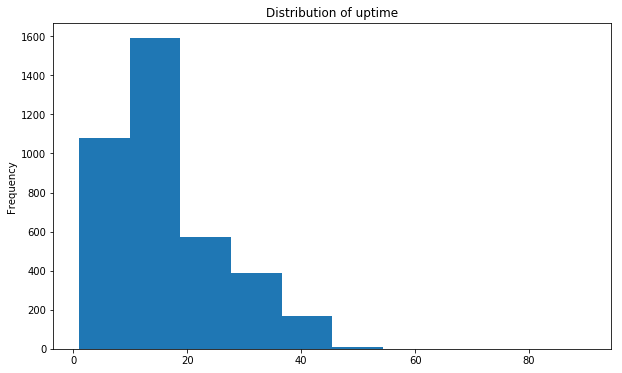

In [76]:
import matplotlib.pyplot as plt
pd_df_uptime.plot.hist(figsize=(10,6), bins=10, title="Distribution of uptime")
plt.show()

We see that most car trains have 10 to 20 uptimes.

For Spark, we would have converted the dataframe to Pandas first and then done what was done above.